# Binary classification based on 3 layers neural network

- This is given by Professor

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision
import os
import sys

from scipy.special import xlogy

import matplotlib.pyplot as plt
import numpy as np
import time


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

 
#train_data_path = 'relative path of training data set'
train_data_path = 'C:\\중앙대 수업자료\\MachineLearningProject\\horse-or-human\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = 'C:\\중앙대 수업자료\\MachineLearningProject\\horse-or-human\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  


- This is given by Professor

In [5]:
train_labels=np.zeros(1027)
test_labels=np.zeros(256)

train_datas=np.zeros((1027,10000))
test_datas=np.zeros((256,10000))



for epoch in range(1):
    sum=0
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        inputs, labels = data
        train_labels[i]=int(labels)
        reinputs=inputs.reshape(10000)
        reinputs=np.array(reinputs)
        train_datas[i]=reinputs
        
    train_datas=train_datas.T

    for i, data in enumerate(valloader):
        sum+=1
        inputs, labels = data
        test_labels[i]=int(labels)
        reinputs=inputs.reshape(10000)
        reinputs=np.array(reinputs)
        test_datas[i]=reinputs

    test_datas=test_datas.T

        

- Function for calculating gradient ReLu

In [15]:
def relu_prime(A):
    dA= np.where(A>0,1,0)
    return dA

- Calculating Accuracy of labels

In [14]:
def accuracy_func(h_,label):
    label_result=np.zeros(len(h_))
    correct=0
    for i in range(len(label)):
        if(h_[i]<0.5):
            label_result[i]=0
        elif(h_[i]>=0.5):
            label_result[i]=1
            
        if(label_result[i]==label[i]):
            correct+=1
    total= correct/len(label)
    
    return total

np.set_printoptions(threshold=sys.maxsize)

- Initialization Train and Validation set.

In [521]:
#set infinite Epoch
NUM_EPOCH=100000000

#loss array
total_loss=np.zeros(NUM_EPOCH)
total_loss_test=np.zeros(NUM_EPOCH)

#accuracy array
accuracy=np.zeros(NUM_EPOCH)
accuracy_test=np.zeros(NUM_EPOCH)

#known_data is weight set
known_data1=np.random.randn(10000,10)*0.1
known_data2=np.random.randn(10,3)*0.1
known_data3=np.random.randn(3,1)*0.1

b_1=np.random.randn(10,1)
b_2=np.random.randn(3,1)
b_3=np.random.randn(1,1)

## ReLu

- Optimization in 3 Layers
- Vertorizing Logistic Regression'c gradient Computation in 3 Layers
- Neural Network Representations
- known_data1 => 10000 x 10 , known_data2 => 10 x 3 ,known_data3 => 3 x 1

In [522]:
#Learning rate
l_rate=0.0072
j=0
#Vertorizing Logistic Regression'c gradient Computation in 3 Layers
for i in range(NUM_EPOCH):
    
    #Forward propagation for train_set
    z1=np.dot(known_data1.T,train_datas)+b_1 #10x1027 =a
    A1=np.maximum(0,z1)
    z2=np.dot(known_data2.T,A1) +b_2 #3x1027=b
    A2=np.maximum(0,z2)
    z3=np.dot(known_data3.T,A2)+b_3 #1x1027=c
    A3=1.0/(1+np.exp(-z3))
    
    #Forward propagation for validation_set
    z1_v=np.dot(known_data1.T,test_datas)+b_1 #10x256=a
    A1_v=np.maximum(0,z1_v)
    z2_v=np.dot(known_data2.T,A1_v)+b_2 #3x256=b
    A2_v=np.maximum(0,z2_v)
    z3_v=np.dot(known_data3.T,A2_v)+b_3 #1x256=c
    A3_v=1.0/(1+np.exp(-z3_v))   
        
    #Calculating total cost
    pre_j=j
    j=-(xlogy(train_labels,A3)+xlogy(1-train_labels,1-A3)).sum()/1027
    j_v=-(xlogy(test_labels,A3_v)+xlogy(1-test_labels,1-A3_v)).sum()/256
    total_loss[i]=j 
    total_loss_test[i]=j_v
    
    #Calculating accuracy
    A3=A3.reshape(1027)
    accuracy[i]=accuracy_func(A3,train_labels)
    A3_v=A3_v.reshape(256)
    accuracy_test[i]=accuracy_func(A3_v,test_labels)
    
    #Break if the train converges.
    if(pre_j==j):
        NUM_EPOCH=i+1
        break
    
    A3=A3.reshape(1,1027)
    A3_v=A3_v.reshape(1,256)

    
    #backpropagation
    L_3=A3-train_labels  #L_3=1x1027
    L_3=L_3.reshape(1,1027)
    L_2=np.multiply(np.dot(known_data3,L_3),relu_prime(A2)) #L_2= 3x1027  
    L_1=np.multiply(np.dot(known_data2,L_2),relu_prime(A1)) #L_1= 10x1027

    #backpropagation first-layer
    dL_3=np.dot(A2,L_3.T)/1027
    known_data3-=l_rate*dL_3
    b3=np.sum(L_3,axis=1,keepdims=True)/1027
    
    #backpropagation second-layer  
    dL_2=np.dot(A1,L_2.T)/1027 #10x3
    known_data2-=l_rate*dL_2
    b2=np.sum(L_2,axis=1,keepdims=True)/1027
    
    #backpropagation third-layer
    dL_1=np.dot(train_datas,L_1.T)/1027 #10000x10
    known_data1-=l_rate*dL_1
    b1=np.sum(L_1,axis=1,keepdims=True)/1027


- Plot the loss of Train and Validation at every iteration

Text(0.5, 0, 'Iteraion')

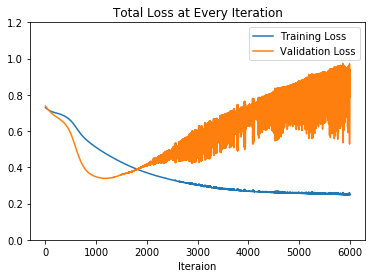

In [526]:
plt.plot(total_loss,label='Training Loss')
plt.plot(total_loss_test,label='Validation Loss')
plt.ylim([0,1.2])
plt.legend(loc='upper right')
plt.title("Total Loss at Every Iteration")
plt.xlabel("Iteraion")

- Plot the Accuracy of Train and Validation 

Text(0.5, 0, 'Iteraion')

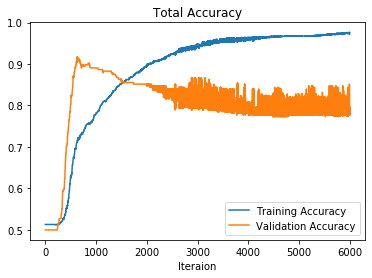

In [524]:
plt.plot(accuracy,label='Training Accuracy')
plt.plot(accuracy_test,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Total Accuracy")
plt.xlabel("Iteraion")

- Present the table for the final accuracy and loss with training and validation datasets
- Accuracy multiply 100 to present as a persent(%)
- Present the table for the accuracy and loss when the best validation accuracy

In [525]:
max_index=np.argmax(accuracy_test)
print("""
                           <At convergence>
+-----------------------------+-----------------------+--------------------+
|       At convergence        |          Loss         |      Accuracy      |
+-----------------------------+-----------------------+--------------------+
|       Training              |         %6.3f        |      %6.2f %%      |
+-----------------------------+-----------------------+--------------------+
|      Validation             |         %6.3f        |      %6.2f %%      |
+-----------------------------+-----------------------+--------------------+

                  <When the best validation accuracy>
+-----------------------+-----------------------+------------------------+
|       Data set        |          Loss         |      Best  Accuracy    |
+-----------------------+-----------------------+------------------------+
|     Validation        |         %6.3f        |         %6.2f %%       |
+-----------------------+-----------------------+------------------------+"""
%(total_loss[NUM_EPOCH-3],accuracy[NUM_EPOCH-1]*100,total_loss_test[NUM_EPOCH-1],accuracy_test[NUM_EPOCH-1300]*100,total_loss_test[max_index],np.max(accuracy_test)*100))


                           <At convergence>
+-----------------------------+-----------------------+--------------------+
|       At convergence        |          Loss         |      Accuracy      |
+-----------------------------+-----------------------+--------------------+
|       Training              |          0.249        |       97.57 %      |
+-----------------------------+-----------------------+--------------------+
|      Validation             |          0.901        |       81.64 %      |
+-----------------------------+-----------------------+--------------------+

                  <When the best validation accuracy>
+-----------------------+-----------------------+------------------------+
|       Data set        |          Loss         |      Best  Accuracy    |
+-----------------------+-----------------------+------------------------+
|     Validation        |          0.484        |          91.80 %       |
+-----------------------+-----------------------+------------